In [28]:
import matplotlib.pyplot as plt
import numpy as np

In [29]:
measurements = np.loadtxt('./observationscoord.csv', delimiter=',')
measurements[:4]

array([[19.48010255,  9.8944439 ],
       [19.49605666, 10.03681057],
       [19.83941132, 11.15508527],
       [20.46463305, 11.002144  ]])

In [30]:
track = np.loadtxt('./trackturn.csv', delimiter=',')

In [31]:
sigma_v = 0.2
sigma_w = 0.001

sigma_y = 0.8

T = 0.5

In [56]:
def f(x : np.ndarray) -> np.ndarray:
    w = x[-1, 0]
    
    a13 = np.sin(w*T) / w
    a14 = (np.cos(w*T) - 1) / w
    a23 = (1 - np.cos(w*T)) / w
    a24 = np.sin(w*T) / w
    a33 = np.cos(w*T)
    a34 = -np.sin(w*T)
    a43 = np.sin(w*T)
    a44 = np.cos(w*T)
    
    return np.array([
        [1, 0, a13, a14, 0],
        [0, 1, a23, a24, 0],
        [0, 0, a33, a34, 0],
        [0, 0, a43, a44, 0],
        [0, 0, 0, 0, 1],
    ]) @ x

In [33]:
Q = np.zeros((5, 5))
Q[0, 0] = T**3 * sigma_v**2 / 3
Q[0, 2] = T**2 * sigma_v**2 / 2
Q[1, 1] = T**3 * sigma_v**2 / 3
Q[1, 3] = T**2 * sigma_v**2 / 2
Q[2, 0] = T**2 * sigma_v**2 / 2
Q[2, 2] = T * sigma_v**2
Q[3, 1] = T**2 * sigma_v**2 / 2
Q[3, 3] = T * sigma_v**2
Q[4, 4] = T * sigma_w**2

Q

array([[1.66666667e-03, 0.00000000e+00, 5.00000000e-03, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 1.66666667e-03, 0.00000000e+00, 5.00000000e-03,
        0.00000000e+00],
       [5.00000000e-03, 0.00000000e+00, 2.00000000e-02, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 5.00000000e-03, 0.00000000e+00, 2.00000000e-02,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.00000000e-07]])

In [55]:
def A(x : np.ndarray) -> np.ndarray:
    x1d = x[-3, 0]
    x2d = x[-2, 0]
    w = x[-1, 0]
    
    a13 = np.sin(T*w)/ w
    a14 = (np.cos(T*w) - 1) / w
    a15 = 1/w**2 * (x2d + (T*w*x1d - x2d) * np.cos(T*w) - (x1d + T*w*x2d) * np.sin(T*w))
    a23 = (1 - np.cos(T*w)) / w
    a24 = np.sin(T*w) / w
    a25 = 1/w**2 * (-x1d + (x1d + T*w*x2d) * np.cos(T*w) + (T*w*x1d - x2d) * np.sin(T*w))
    a33 = np.cos(T*w)
    a34 = -np.sin(T*w)
    a35 = -T * (x2d*np.cos(T*w) + x1d*np.sin(T*w))
    a43 = np.sin(T*w)
    a44 = np.cos(T*w)
    a45 = T * (x1d*np.cos(T*w) - x2d*np.sin(T*w))
    
    return np.array([
        [1, 0, a13, a14, a15],
        [0, 1, a23, a24, a25],
        [0, 0, a33, a34, a35],
        [0, 0, a43, a44, a45],
        [0, 0, 0, 0, 1],
    ])

In [35]:
R = np.eye(2) * sigma_y**2

In [36]:
C = np.array([
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
])

In [37]:
def kalman_filter(x0, P0, Q, R):

    x = x0.copy()
    P = P0.copy()

    xarr = [x0]

    for measurement in measurements:
        x_est = f(x)
        P_est = A(x) @ P @ A(x).T + Q
        
        y = measurement.reshape(-1, 1)
        y_est = C @ x_est
        dy = y - y_est
        
        S = C @ P_est @ C.T + R
        F = P_est @ C.T @ np.linalg.inv(S)
        
        x = x_est + F @ dy
        P = (np.eye(x0.shape[0]) - F @ C) @ P_est
        
        xarr.append(x)
        
    xarr = np.array(xarr).squeeze()
    return xarr

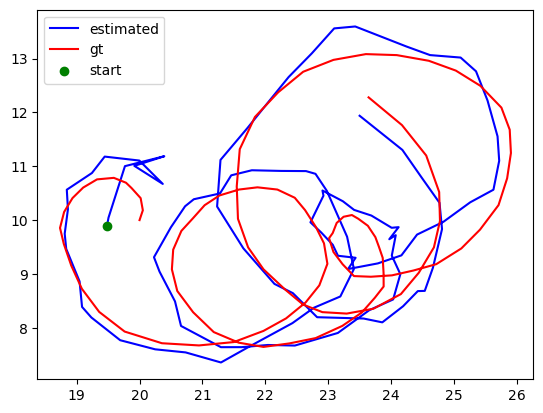

In [38]:
x0 = np.hstack([measurements[0, :], [1, 1, 0.02]]).reshape(-1, 1)
P0 = np.eye(x0.shape[0]) * 100

xarr = kalman_filter(x0, P0, Q, R)

plt.plot(xarr[:, 0], xarr[:, 1], color='b', label='estimated')
plt.plot(track[:, 0], track[:, 1], color='red', label='gt')
plt.scatter(measurements[0, 0], measurements[0, 1], color='g', label='start', zorder=2)

plt.legend()
plt.show()

### 2 Полярные измерения

In [39]:
new_measurements = np.loadtxt('./observationspolar.csv', delimiter=',')
new_measurements[:4]

array([[22.32326496,  0.4531741 ],
       [22.66412141,  0.4808012 ],
       [22.34380635,  0.48776666],
       [22.41305912,  0.50138856]])

In [40]:
R2 = np.array([
    [1, 0],
    [0, 0.02],
])

In [41]:
# import sympy as sp

# x1, x2 = sp.symbols('x1, x2')

# r = sp.sqrt(x1**2 + x2**2)
# phi = sp.atan2(x2, x1)
# sp.diff(r, x1)
# sp.diff(phi, x2)

In [42]:
def h(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    
    return np.array([
        [np.sqrt(x1**2 + x2**2)],
        [np.arctan2(x2, x1)],
    ])

In [43]:
def H(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    
    return np.array([
        [x1 / np.sqrt(x1**2 + x2**2), x2 / np.sqrt(x1**2 + x2**2), 0, 0, 0],
        [-x2 / (x1**2 + x2**2), x1 / (x1**2 + x2**2), 0, 0, 0]
    ])

In [44]:
def kalman_filter2(x0, P0, Q, R):

    x = x0.copy()
    P = P0.copy()

    xarr = [x0]

    for measurement in new_measurements:
        x_est = f(x)
        P_est = A(x) @ P @ A(x).T + Q
        
        y = measurement.reshape(-1, 1)
        y_est = h(x_est)
        dy = y - y_est
        
        S = H(x_est) @ P_est @ H(x_est).T + R
        F = P_est @ H(x_est).T @ np.linalg.inv(S)
        
        x = x_est + F @ dy
        P = (np.eye(x0.shape[0]) - F @ H(x_est)) @ P_est
        
        xarr.append(x)
        
    xarr = np.array(xarr).squeeze()
    return xarr

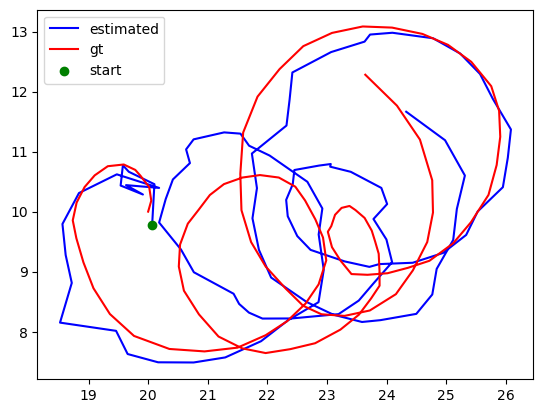

In [45]:
start0 = new_measurements[0, 0] * np.cos(new_measurements[0, 1])
start1 = new_measurements[0, 0] * np.sin(new_measurements[0, 1])

x0 = np.hstack([start0, start1, [1, 1, 1]]).reshape(-1, 1)
P0 = np.eye(x0.shape[0]) * 100

xarr = kalman_filter2(x0, P0, Q, R2)

plt.plot(xarr[:, 0], xarr[:, 1], color='b', label='estimated')
plt.plot(track[:, 0], track[:, 1], color='red', label='gt')
plt.scatter(start0, start1, color='g', label='start', zorder=2)

plt.legend()
plt.show()

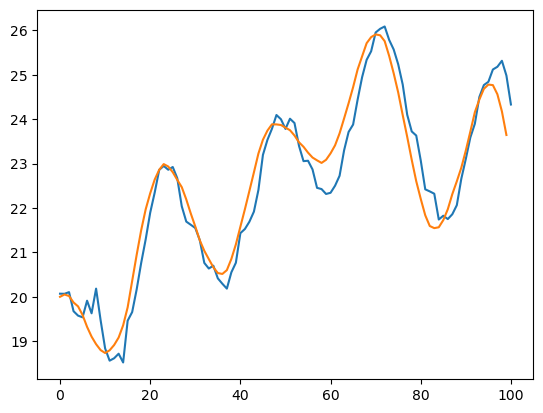

In [46]:
plt.plot(xarr[:, 0])
plt.plot(track[:, 0])

plt.show()

### 3 Сигматочечный EKF

In [47]:
def get_sigma_points(mean, P):
    z0 = mean
    w0 = 1/25.#0.5
    zarr, warr = [z0], [w0]

    n = P.shape[0]
    
    S = np.linalg.cholesky(P)
    
    for j in range(n):
        b = S[:, j].reshape(-1, 1)
        
        zp = (mean + np.sqrt(n / (1 - w0)) * b)
        zarr.append(zp)
        warr.append((1 - w0) / 2 / n)
        
        zm = (mean - np.sqrt(n / (1 - w0)) * b)
        zarr.append(zm)
        warr.append((1 - w0) / 2 / n)
        
    return warr, zarr

In [48]:
def fa(x):
    return np.vstack([f(x[:Q.shape[0]]) + x[Q.shape[0]:Q.shape[0]*2], x[Q.shape[0]:]])

In [49]:
def kalman_filter3(x0, P0, Q, R):

    x = x0.copy()
    P = P0.copy()

    xarr = [x0]

    for measurement in new_measurements:
        warr, zarr = get_sigma_points(x, P)
        
        x_est = np.zeros_like(x0)
        x_list = []
        
        y_est = np.zeros((R.shape[0], 1))
        y_list = []
        
        for w, z in zip(warr, zarr):
            x_val = fa(z)
            x_list.append(x_val)
            x_est += w * x_val
            
            y_val = h(x_val[:Q.shape[0]]) + x_val[-2:]
            y_list.append(y_val)
            y_est += w * y_val
            
        P_est = np.zeros_like(P)
        S = np.zeros_like(R)
        W = np.zeros((x_est.shape[0], y_est.shape[0]))
        for w, x_val, y_val in zip(warr, x_list, y_list):
            P_est += w * (x_val - x_est) @ (x_val - x_est).T
            S += w * (y_val - y_est) @ (y_val - y_est).T
            W += w * (x_val - x_est) @ (y_val - y_est).T
        
        y = measurement.reshape(-1, 1)
        dy = y - y_est
        
        F = W @ np.linalg.inv(S)
        
        x = x_est + F @ dy
        P = P_est - F @ S @ F.T
        
        xarr.append(x)
        
    xarr = np.array(xarr).squeeze()
    return xarr

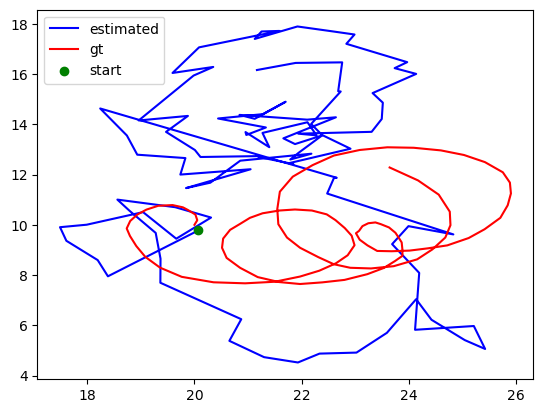

In [54]:
start0 = new_measurements[0, 0] * np.cos(new_measurements[0, 1])
start1 = new_measurements[0, 0] * np.sin(new_measurements[0, 1])

x0 = np.hstack([start0, start1, [1, 1, 1], np.ones(5)*0.2, np.zeros(2)]).reshape(-1, 1) # x1, x2, v1, v2, w, err_x (5), err y (2)

P0_x = np.eye(Q.shape[0]) * 100
P0 = np.zeros((x0.shape[0], x0.shape[0]))
P0[:Q.shape[0], :Q.shape[0]] = P0_x
P0[Q.shape[0]:Q.shape[0]*2, Q.shape[0]:Q.shape[0]*2] = Q
P0[C.shape[1]+5:, C.shape[1]+5:] = R2
P0 += np.eye(P0.shape[0]) * 1e-1

xarr = kalman_filter3(x0, P0, Q, R2)

plt.plot(xarr[:, 0], xarr[:, 1], color='b', label='estimated')
plt.plot(track[:, 0], track[:, 1], color='red', label='gt')
plt.scatter(start0, start1, color='g', label='start', zorder=2)

plt.legend()
plt.show()

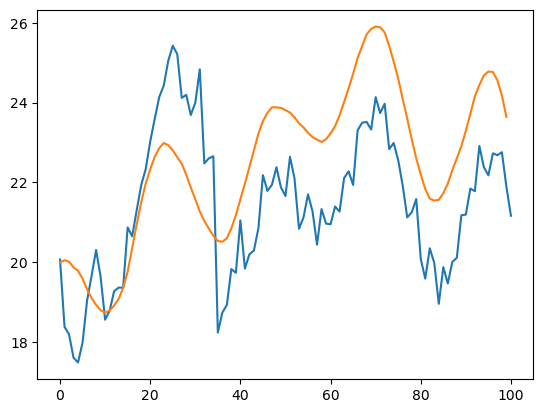

In [51]:
plt.plot(xarr[:, 0])
plt.plot(track[:, 0])
plt.show()

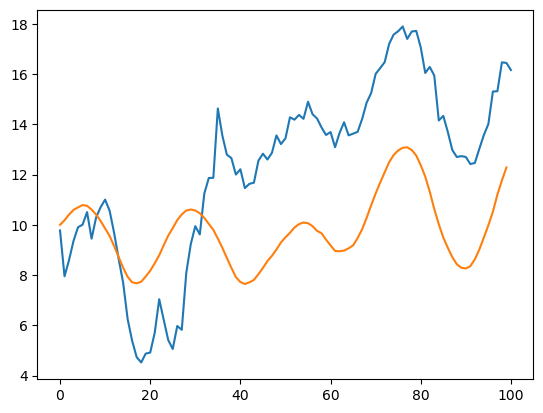

In [52]:
plt.plot(xarr[:, 1])
plt.plot(track[:, 1])
plt.show()